#TIỀN XỬ LÝ DỮ LIỆU (Preprocessing)

In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Imports cho tiền xử lý
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer              # Dùng để xử lý dữ liệu thiếu
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder # Chuẩn hóa và Mã hóa
from sklearn.compose import ColumnTransformer          # Dùng để xử lý đồng thời các cột
from sklearn.pipeline import Pipeline                  # Để kết hợp các bước xử lý

# 1. Đọc dữ liệu
FILE_PATH = "https://raw.githubusercontent.com/duongkienvn/Machine-Learning-Project/refs/heads/duongkien/kidney_disease.csv"
df = pd.read_csv(FILE_PATH, na_values=['?', ' ', '\t'])

print("Đã dùng dữ liệu CKD. Kích thước:", df.shape)

# 2. Hiển thị 5 dòng đầu tiên
print("\n--- 5 dòng dữ liệu đầu tiên: ---")
print(df.head(5))

# 3. Mô tả cấu trúc (các trường, kiểu dữ liệu, số bản ghi, dữ liệu thiếu)
print("\n--- Thông tin (info) của DataFrame: ---")
df.info()

# 4. Thống kê sơ bộ về dữ liệu
# Cho các cột số (numerical)
print("\n--- Thống kê các cột số: ---")
print(df.describe())

# Cho các cột chữ/lựa chọn (categorical)
print("\n--- Thống kê các cột category: ---")
print(df.describe(include=['object', 'category']))

# --- Chuẩn hóa dữ liệu lỗi ---
print("\n--- XỬ LÝ DỮ LIỆU LỖI ---")

# 1. Xử lý cột không cần thiết
if 'id' in df.columns:
    df = df.drop('id', axis=1)
    print("Đã xóa cột 'id'.")

# 2. Kiểm tra duplicates
duplicates = df.duplicated().sum()
print(f"Tìm thấy {duplicates} bản ghi trùng lặp.")
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Đã xóa các bản ghi trùng lặp. Kích thước mới: {df.shape}")

# 3. Kiểm tra và xử lý dữ liệu thiếu (Missing Data)
print("\n--- Tổng số dữ liệu thiếu (NaN) mỗi cột (sau khi xử lý '?'): ---")
print(df.isnull().sum())

# --- Chuyển đổi và Chuẩn hóa (Xây dựng Pipeline) ---
print("\n---XÂY DỰNG PIPELINE TIỀN XỬ LÝ ---")

# 1. Tách biến mục tiêu (y) và biến độc lập (X)
TARGET_COLUMN = 'classification'

df = df.dropna(subset=[TARGET_COLUMN])
print(f"Đã xóa các hàng có target (y) bị thiếu. Kích thước mới: {df.shape}")

# Xử lý y (biến mục tiêu)
y = df[TARGET_COLUMN]

y = y.str.strip() # Xóa các khoảng trắng (ví dụ: ' ckd' -> 'ckd')
y = y.replace('ckd[]', 'ckd') # Sửa lỗi 'ckd[]' -> 'ckd'

le = LabelEncoder()
y = le.fit_transform(y)
print(f"Đã mã hóa cột mục tiêu '{TARGET_COLUMN}'. Các lớp: {le.classes_}")

X = df.drop(TARGET_COLUMN, axis=1)

# 2. Xác định các nhóm cột
numerical_cols = [
    'age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc'
]

categorical_cols = [
    'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad',
    'appet', 'pe', 'ane'
]

# Kiểm tra xem có cột nào bị sót không
processed_cols = numerical_cols + categorical_cols
unprocessed = [col for col in X.columns if col not in processed_cols]
print(f"Các cột số: {numerical_cols}")
print(f"Các cột category: {categorical_cols}")
print(f"Các cột bị bỏ quên (nếu có): {unprocessed}")

print("\n--- Đang chuyển đổi kiểu dữ liệu bắt buộc ---")
for col in numerical_cols:
    # errors='coerce' sẽ biến các giá trị không hợp lệ (nếu có) thành NaN
    X[col] = pd.to_numeric(X[col], errors='coerce')

for col in categorical_cols:
    # Đảm bảo các cột category là dạng 'str' để imputer hoạt động
    X[col] = X[col].astype(str)

print("Đã chuyển đổi kiểu dữ liệu cho X.")

# 3. Xây dựng Pipeline cho từng loại cột

# 3.1. Pipeline xử lý cột SỐ (Numerical):
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),   # Xử lý thiếu trường (NaN)
    ('scaler', StandardScaler())                    # Chuẩn hóa giá trị
])

# 3.2. Pipeline xử lý cột CHỮ (Categorical):
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))   # Chuyển đổi dữ liệu
])

# 4. Kết hợp 2 pipeline bằng ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough' # Giữ nguyên các cột không được xử lý (nếu có)
)

# 5. Áp dụng pipeline vào dữ liệu X
print("\nĐang áp dụng pipeline tiền xử lý (Imputing, Scaling, One-Hot Encoding)...")
X_processed = preprocessor.fit_transform(X)
print("Áp dụng pipeline thành công!")


# --- Mô tả dữ liệu sau chuẩn hóa ---

print("\n--- MÔ TẢ DỮ LIỆU SAU CHUẨN HÓA ---")

# 1. Lấy tên các cột mới sau khi One-Hot
try:
    num_feature_names = numerical_cols
    cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
    all_feature_names = list(num_feature_names) + list(cat_feature_names)

    df_processed = pd.DataFrame(X_processed, columns=all_feature_names)

    print("\n--- 5 dòng đầu của dữ liệu đã tiền xử lý: ---")
    print(df_processed.head())

    # 5. Thống kê dữ liệu sau chuẩn hóa
    print("\n--- Thống kê dữ liệu đã tiền xử lý: ---")
    print(df_processed.describe())

except Exception as e:
    print(f"\nKhông thể tạo DataFrame (có thể do lỗi sparse matrix): {e}")
    print("In X_processed (dạng numpy array) 5 dòng đầu:")
    print(X_processed[:5])


# 4. Mô tả cấu trúc mới
print("\n--- Info của dữ liệu đã tiền xử lý (dạng numpy): ---")
print(f"Kiểu dữ liệu: {type(X_processed)}, Shape: {X_processed.shape}")


print(f"\nKích thước dữ liệu gốc (X) (đã lọc target NaN): {X.shape}")
print(f"Kích thước dữ liệu sau xử lý (X_processed): {X_processed.shape}")
print(f"Kích thước nhãn (y): {y.shape}")

Đã dùng dữ liệu CKD. Kích thước: (400, 26)

--- 5 dòng dữ liệu đầu tiên: ---
   id   age    bp     sg   al   su     rbc        pc         pcc          ba  \
0   0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2   2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3   3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4   4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

   ...  pcv    wc   rc  htn   dm  cad appet   pe  ane classification  
0  ...   44  7800  5.2  yes  yes   no  good   no   no            ckd  
1  ...   38  6000  NaN   no   no   no  good   no   no            ckd  
2  ...   31  7500  NaN   no  yes   no  poor   no  yes            ckd  
3  ...   32  6700  3.9  yes   no   no  poor  yes  yes            ckd  
4  ...   35  7300  4.6   no   no   no  good   no   no            ckd  

[5 rows x 26 co

# Mô hình Phân tích Giảm chiều và Phân loại K-NN

**Imports**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Cài đặt chung cho đồ thị
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_theme(style="whitegrid")


**PCA: Phân tích và giảm chiều**


--- PHÂN TÍCH VÀ GIẢM CHIỀU ---

--- Đang thực hiện PCA ---


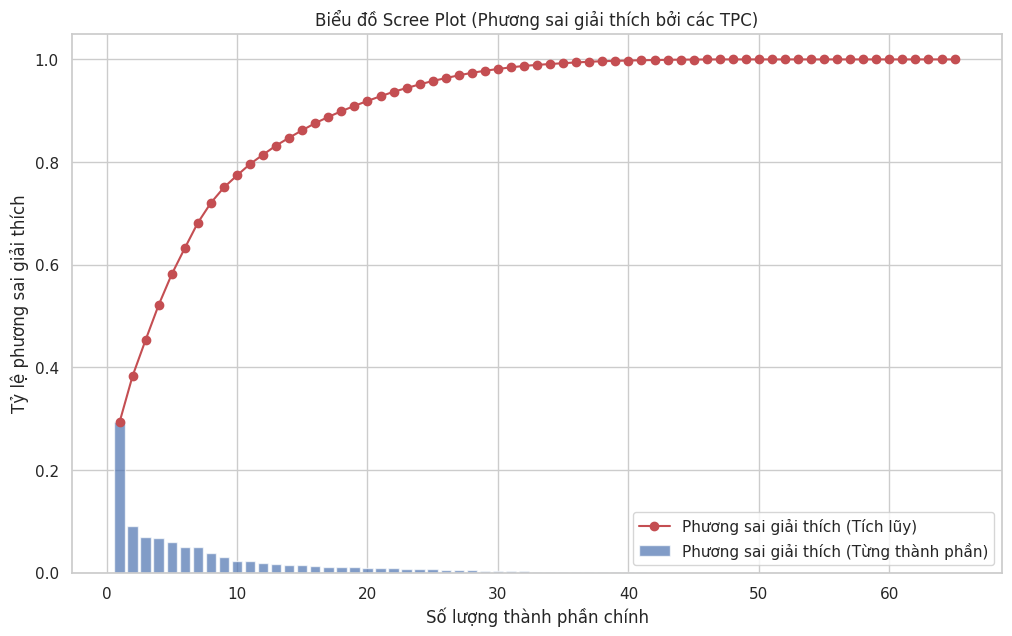

Tổng số chiều ban đầu: 65
Phương sai giải thích bởi 4 thành phần đầu: 0.5219
Phương sai giải thích bởi 6 thành phần đầu: 0.6324


In [ ]:
################################################################################
##
## PHÂN TÍCH VÀ GIẢM CHIỀU DỮ LIỆU
##
################################################################################

print("\n--- PHÂN TÍCH VÀ GIẢM CHIỀU ---")

# --- Phương pháp PCA (Principal Component Analysis) ---
print("\n--- Đang thực hiện PCA ---")

# 1. Tính toán PCA với toàn bộ số chiều để vẽ biểu đồ phương sai
pca_full = PCA(n_components=None, random_state=42)
pca_full.fit(X_processed)

# 2. Tính toán và vẽ biểu đồ phương sai giải thích (Explained Variance)
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(12, 7))
bars = plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center',
               label='Phương sai giải thích (Từng thành phần)')
line = plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, 'r-o',
                label='Phương sai giải thích (Tích lũy)')

plt.ylabel('Tỷ lệ phương sai giải thích')
plt.xlabel('Số lượng thành phần chính')
plt.title('Biểu đồ Scree Plot (Phương sai giải thích bởi các TPC)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# In ra thông tin
print(f"Tổng số chiều ban đầu: {X_processed.shape[1]}")
print(f"Phương sai giải thích bởi 4 thành phần đầu: {cumulative_variance[3]:.4f}")
print(f"Phương sai giải thích bởi 6 thành phần đầu: {cumulative_variance[5]:.4f}")


**PCA: Giảm chiều và trực quan hóa**

Đã giảm chiều PCA xuống 6 thành phần. Shape mới: (400, 6)
Đang vẽ Pairplot cho 4 thành phần chính đầu tiên...


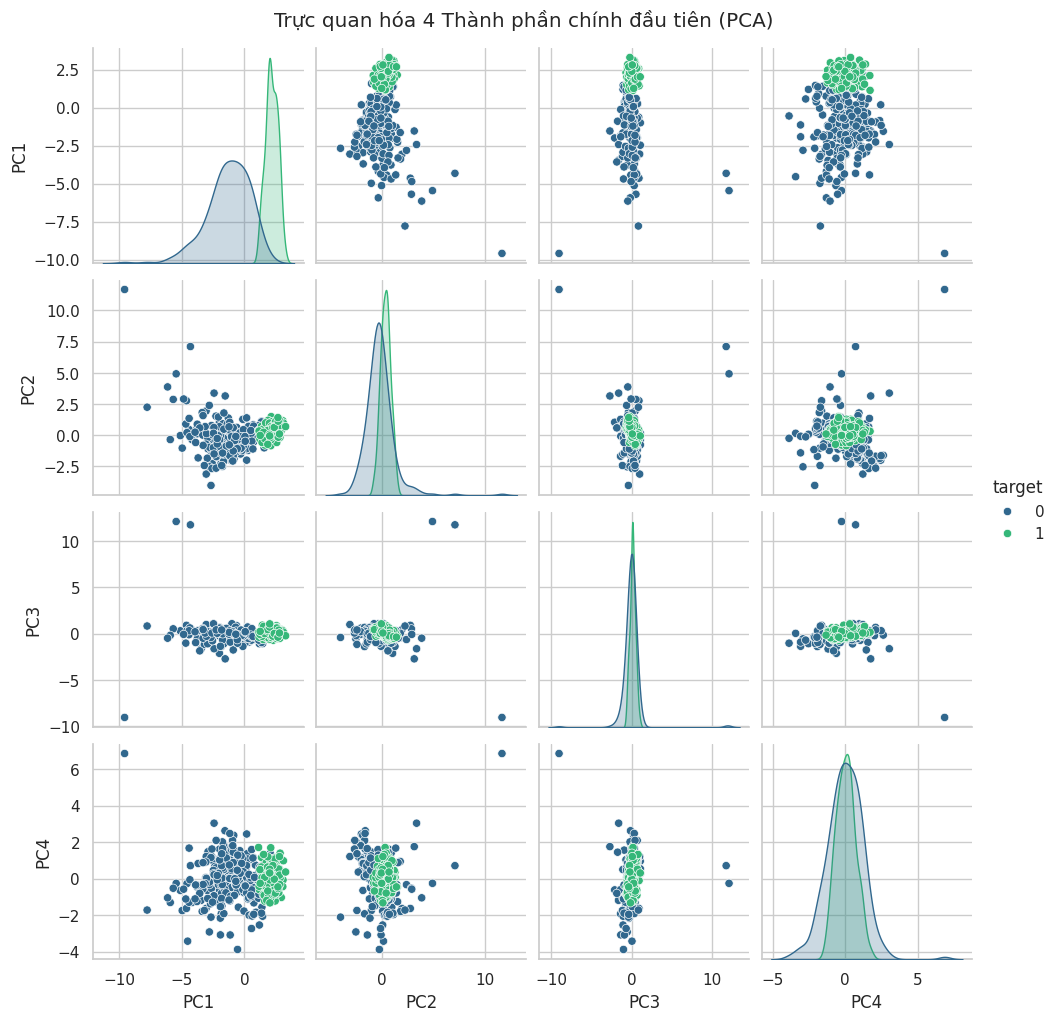

In [ ]:
# 3. Áp dụng PCA để giảm chiều
N_COMPONENTS_PCA = 6
pca = PCA(n_components=N_COMPONENTS_PCA, random_state=42)
X_pca = pca.fit_transform(X_processed)

print(f"Đã giảm chiều PCA xuống {N_COMPONENTS_PCA} thành phần. Shape mới: {X_pca.shape}")

# 4. Trực quan hóa dữ liệu sau khi giảm chiều (4-6 thành phần đầu)
pca_cols = [f'PC{i+1}' for i in range(N_COMPONENTS_PCA)]
df_pca = pd.DataFrame(data=X_pca, columns=pca_cols)
df_pca['target'] = y

print("Đang vẽ Pairplot cho 4 thành phần chính đầu tiên...")
sns.pairplot(df_pca, vars=pca_cols[:4], hue='target', palette='viridis')
plt.suptitle('Trực quan hóa 4 Thành phần chính đầu tiên (PCA)', y=1.02)
plt.show()


**LDA: Phân tích và giảm chiều**


--- Đang thực hiện LDA ---
Đã giảm chiều LDA xuống 1 thành phần. Shape mới: (400, 1)


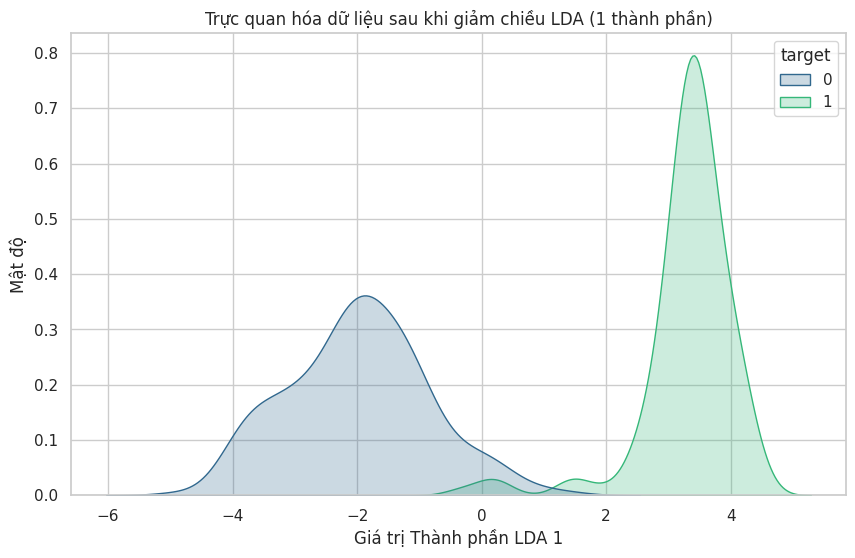

In [ ]:
# --- Phương pháp LDA (Linear Discriminant Analysis) ---
print("\n--- Đang thực hiện LDA ---")

# 1. Áp dụng LDA
N_COMPONENTS_LDA = 1
lda = LDA(n_components=N_COMPONENTS_LDA)
X_lda = lda.fit_transform(X_processed, y)

print(f"Đã giảm chiều LDA xuống {N_COMPONENTS_LDA} thành phần. Shape mới: {X_lda.shape}")

# 2. Trực quan hóa dữ liệu sau khi giảm chiều (1 thành phần)
df_lda = pd.DataFrame(data=X_lda, columns=['LDA1'])
df_lda['target'] = y

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_lda, x='LDA1', hue='target', fill=True, common_norm=False, palette='viridis')
plt.title('Trực quan hóa dữ liệu sau khi giảm chiều LDA (1 thành phần)')
plt.xlabel('Giá trị Thành phần LDA 1')
plt.ylabel('Mật độ')
plt.show()


**So sánh PCA vs LDA**

In [ ]:
# --- So sánh PCA và LDA ---
print("\n--- So sánh PCA vs LDA ---")
print("""
- PCA (Phân tích Thành phần chính):
  + Là phương pháp học không giám sát (chỉ dùng X).
  + Mục tiêu: Tìm các trục (thành phần) để tối đa hóa phương sai của dữ liệu.
  + Giữ lại cấu trúc tổng thể của dữ liệu.
  + Số thành phần có thể chọn (tối đa bằng số chiều).

- LDA (Phân tích Phân biệt Tuyến tính):
  + Là phương pháp học có giám sát (dùng cả X và y).
  + Mục tiêu: Tìm các trục để tối đa hóa khả năng phân tách giữa các lớp.
  + Tập trung vào việc phân loại.
  + Số thành phần bị giới hạn (tối đa = số lớp - 1). Với bài toán này là 1.
""")



--- So sánh PCA vs LDA ---

- PCA (Phân tích Thành phần chính):
  + Là phương pháp học không giám sát (chỉ dùng X).
  + Mục tiêu: Tìm các trục (thành phần) để tối đa hóa phương sai của dữ liệu.
  + Giữ lại cấu trúc tổng thể của dữ liệu.
  + Số thành phần có thể chọn (tối đa bằng số chiều).

- LDA (Phân tích Phân biệt Tuyến tính):
  + Là phương pháp học có giám sát (dùng cả X và y).
  + Mục tiêu: Tìm các trục để tối đa hóa khả năng phân tách giữa các lớp.
  + Tập trung vào việc phân loại.
  + Số thành phần bị giới hạn (tối đa = số lớp - 1). Với bài toán này là 1.



**Hàm huấn luyện & đánh giá KNN**

In [ ]:
################################################################################
##
## PHÂN LOẠI (MÔ HÌNH K-NN)
##
################################################################################

print("\n--- PHÂN LOẠI K-NN ---")


# Hàm trợ giúp để chạy và báo cáo kết quả
def run_knn_experiment(X_data, y_data, dataset_name, test_size):
    """
    Hàm thực hiện huấn luyện, đánh giá K-NN và vẽ Confusion Matrix.
    """
    print("--------------------------------------------------")
    print(f"THỰC NGHIỆM: K-NN")
    print(f"   - Dữ liệu: {dataset_name}")
    print(f"   - Tỉ lệ chia (test_size): {test_size:.1f} (Train {1-test_size:.1f} : Test {test_size:.1f})")

    # 1. Chia dữ liệu
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                        test_size=test_size,
                                                        random_state=42,
                                                        stratify=y_data)


    # 2. Khởi tạo và Huấn luyện mô hình
    k = 11
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)

    # 3. Dự đoán
    y_pred = model.predict(X_test)

    # 4. Đánh giá
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n   -> Kết quả:")
    print(f"      - Accuracy: {accuracy:.4f}")

    print("\n      - Báo cáo Phân loại (Classification Report):")
    # Thêm zero_division=0 để tránh lỗi khi 1 lớp không có dự đoán nào
    print(classification_report(y_test, y_pred, zero_division=0))

    # 5. Trực quan hóa kết quả (Confusion Matrix)
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues, colorbar=False)
    plt.title(f'Confusion Matrix: K-NN trên {dataset_name} (Test Size={test_size:.1f})')
    plt.show()
    print("--------------------------------------------------")

    return accuracy



--- PHÂN LOẠI K-NN ---


**Danh sách các bộ dữ liệu và tỉ lệ chia**

In [ ]:
# --- Tiến hành chạy các thực nghiệm ---

# Danh sách các bộ dữ liệu
datasets_to_run = {
    "Dữ liệu Gốc": X_processed,
    "Dữ liệu PCA (6 CPs)": X_pca,
    "Dữ liệu LDA (1 CP)": X_lda
}

# Danh sách các tỉ lệ chia
splits_to_run = {
    "4:1": 0.2,
    "7:3": 0.3,
    "6:4": 0.4
}


**Chạy tất cả thực nghiệm**


ĐANG CHẠY MÔ HÌNH TRÊN BỘ DỮ LIỆU: DỮ LIỆU GỐC
--------------------------------------------------
THỰC NGHIỆM: K-NN
   - Dữ liệu: Dữ liệu Gốc
   - Tỉ lệ chia (test_size): 0.2 (Train 0.8 : Test 0.2)

   -> Kết quả:
      - Accuracy: 0.9750

      - Báo cáo Phân loại (Classification Report):
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        50
           1       0.94      1.00      0.97        30

    accuracy                           0.97        80
   macro avg       0.97      0.98      0.97        80
weighted avg       0.98      0.97      0.98        80



<Figure size 800x600 with 0 Axes>

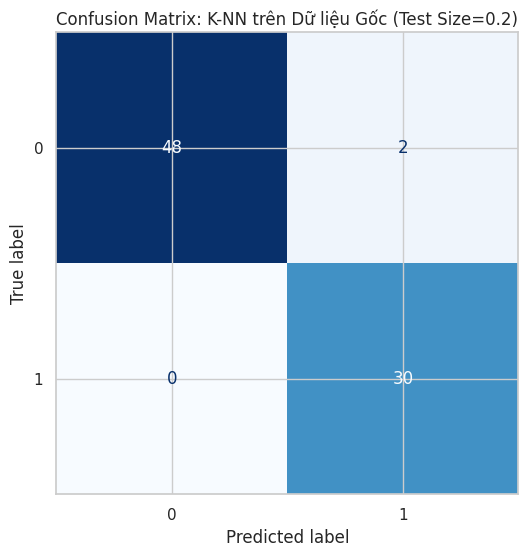

--------------------------------------------------
--------------------------------------------------
THỰC NGHIỆM: K-NN
   - Dữ liệu: Dữ liệu Gốc
   - Tỉ lệ chia (test_size): 0.3 (Train 0.7 : Test 0.3)

   -> Kết quả:
      - Accuracy: 0.9750

      - Báo cáo Phân loại (Classification Report):
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        75
           1       0.94      1.00      0.97        45

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.98      0.97      0.98       120



<Figure size 800x600 with 0 Axes>

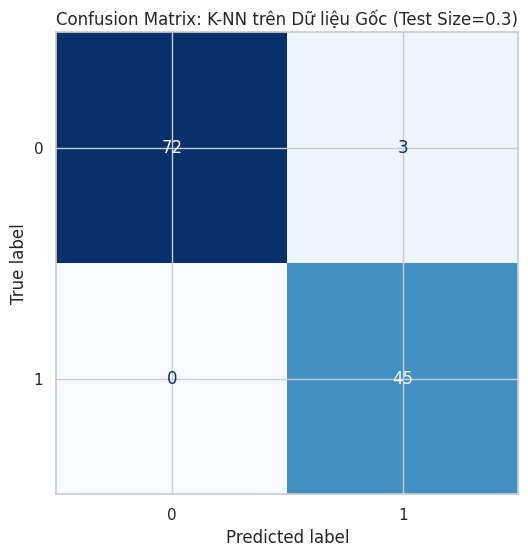

--------------------------------------------------
--------------------------------------------------
THỰC NGHIỆM: K-NN
   - Dữ liệu: Dữ liệu Gốc
   - Tỉ lệ chia (test_size): 0.4 (Train 0.6 : Test 0.4)

   -> Kết quả:
      - Accuracy: 0.9500

      - Báo cáo Phân loại (Classification Report):
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       100
           1       0.88      1.00      0.94        60

    accuracy                           0.95       160
   macro avg       0.94      0.96      0.95       160
weighted avg       0.96      0.95      0.95       160



<Figure size 800x600 with 0 Axes>

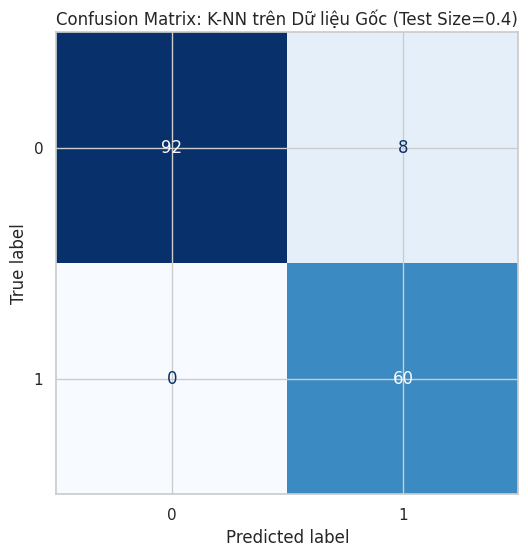

--------------------------------------------------

ĐANG CHẠY MÔ HÌNH TRÊN BỘ DỮ LIỆU: DỮ LIỆU PCA (6 CPS)
--------------------------------------------------
THỰC NGHIỆM: K-NN
   - Dữ liệu: Dữ liệu PCA (6 CPs)
   - Tỉ lệ chia (test_size): 0.2 (Train 0.8 : Test 0.2)

   -> Kết quả:
      - Accuracy: 0.9875

      - Báo cáo Phân loại (Classification Report):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.97      1.00      0.98        30

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



<Figure size 800x600 with 0 Axes>

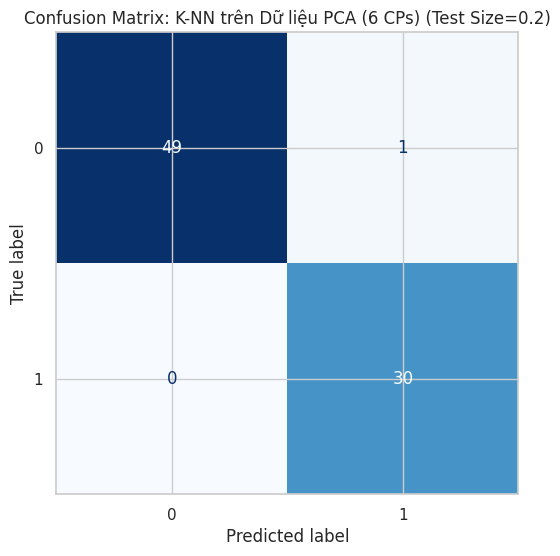

--------------------------------------------------
--------------------------------------------------
THỰC NGHIỆM: K-NN
   - Dữ liệu: Dữ liệu PCA (6 CPs)
   - Tỉ lệ chia (test_size): 0.3 (Train 0.7 : Test 0.3)

   -> Kết quả:
      - Accuracy: 0.9833

      - Báo cáo Phân loại (Classification Report):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        75
           1       0.96      1.00      0.98        45

    accuracy                           0.98       120
   macro avg       0.98      0.99      0.98       120
weighted avg       0.98      0.98      0.98       120



<Figure size 800x600 with 0 Axes>

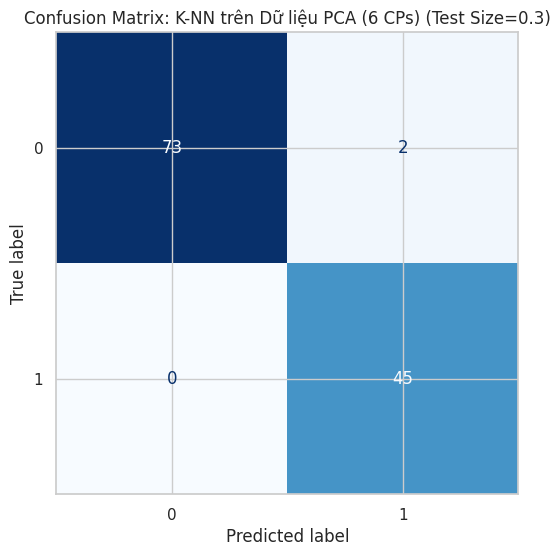

--------------------------------------------------
--------------------------------------------------
THỰC NGHIỆM: K-NN
   - Dữ liệu: Dữ liệu PCA (6 CPs)
   - Tỉ lệ chia (test_size): 0.4 (Train 0.6 : Test 0.4)

   -> Kết quả:
      - Accuracy: 0.9688

      - Báo cáo Phân loại (Classification Report):
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       100
           1       0.92      1.00      0.96        60

    accuracy                           0.97       160
   macro avg       0.96      0.97      0.97       160
weighted avg       0.97      0.97      0.97       160



<Figure size 800x600 with 0 Axes>

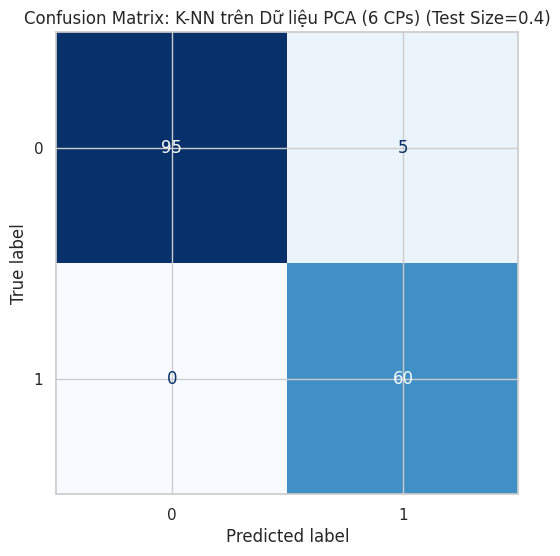

--------------------------------------------------

ĐANG CHẠY MÔ HÌNH TRÊN BỘ DỮ LIỆU: DỮ LIỆU LDA (1 CP)
--------------------------------------------------
THỰC NGHIỆM: K-NN
   - Dữ liệu: Dữ liệu LDA (1 CP)
   - Tỉ lệ chia (test_size): 0.2 (Train 0.8 : Test 0.2)

   -> Kết quả:
      - Accuracy: 1.0000

      - Báo cáo Phân loại (Classification Report):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        30

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



<Figure size 800x600 with 0 Axes>

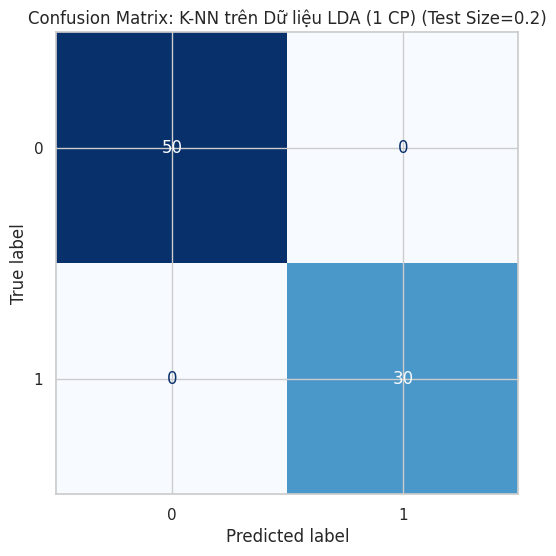

--------------------------------------------------
--------------------------------------------------
THỰC NGHIỆM: K-NN
   - Dữ liệu: Dữ liệu LDA (1 CP)
   - Tỉ lệ chia (test_size): 0.3 (Train 0.7 : Test 0.3)

   -> Kết quả:
      - Accuracy: 0.9917

      - Báo cáo Phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        75
           1       1.00      0.98      0.99        45

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



<Figure size 800x600 with 0 Axes>

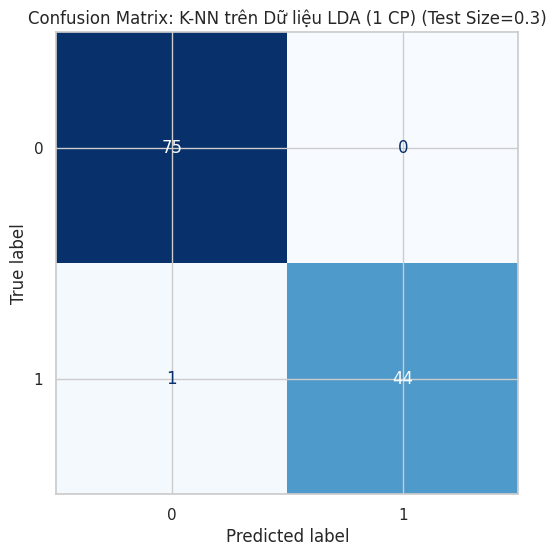

--------------------------------------------------
--------------------------------------------------
THỰC NGHIỆM: K-NN
   - Dữ liệu: Dữ liệu LDA (1 CP)
   - Tỉ lệ chia (test_size): 0.4 (Train 0.6 : Test 0.4)

   -> Kết quả:
      - Accuracy: 0.9938

      - Báo cáo Phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       100
           1       1.00      0.98      0.99        60

    accuracy                           0.99       160
   macro avg       1.00      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160



<Figure size 800x600 with 0 Axes>

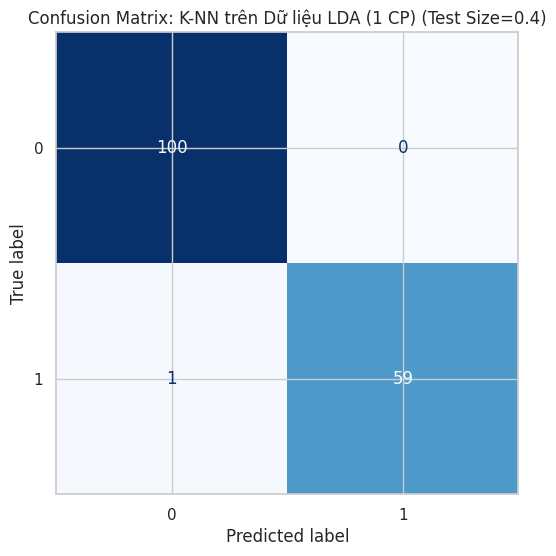

--------------------------------------------------


In [ ]:
# Lặp qua tất cả các kịch bản
results = {}
for dataset_name, data in datasets_to_run.items():
    results[dataset_name] = {}
    print(f"\n==================================================")
    print(f"ĐANG CHẠY MÔ HÌNH TRÊN BỘ DỮ LIỆU: {dataset_name.upper()}")
    print(f"==================================================")

    for split_name, test_size in splits_to_run.items():
        acc = run_knn_experiment(data, y, dataset_name, test_size)
        results[dataset_name][split_name] = acc


**Tổng kết kết quả**

In [ ]:
# --- Tổng kết kết quả ---
print("\n\n##################################################")
print(" TỔNG KẾT KẾT QUẢ ACCURACY (K-NN)")
print("##################################################")

df_results = pd.DataFrame(results)
print(df_results)



##################################################
 TỔNG KẾT KẾT QUẢ ACCURACY (K-NN)
##################################################
     Dữ liệu Gốc  Dữ liệu PCA (6 CPs)  Dữ liệu LDA (1 CP)
4:1        0.975             0.987500            1.000000
7:3        0.975             0.983333            0.991667
6:4        0.950             0.968750            0.993750


# Đánh giá Hiệu suất Mô hình K-Nearest Neighbors (K-NN)

**Tổng quan và So sánh Kết quả**

Mô hình K-NN (K-Nearest Neighbors) cho thấy hiệu suất cực kỳ tốt trên bộ dữ liệu Bệnh thận mạn tính (CKD), với độ chính xác (Accuracy) trên tập kiểm tra luôn duy trì ở mức rất cao, dao động từ 95.0% đến 100% trong tất cả các kịch bản.

Chúng ta có thể so sánh hiệu suất dựa trên ba loại dữ liệu đầu vào:

1. Dữ liệu LDA (1 Đặc trưng): Đây là trường hợp cho kết quả ấn tượng nhất. Với một đặc trưng duy nhất do LDA tạo ra, mô hình K-NN đạt độ chính xác 100% (ở split 80:20) và 99.17% - 99.38% ở các split khác. Điều này chứng tỏ một thành phần duy nhất của LDA đã tìm ra được một trục phân tách tuyến tính gần như hoàn hảo hai lớp ckd và notckd.
2. Dữ liệu PCA (6 Đặc trưng): Mô hình đạt độ chính xác rất cao (96.88% - 98.75%). Kết quả này cao hơn một chút so với khi sử dụng dữ liệu gốc, cho thấy việc giảm chiều xuống 6 thành phần chính đã giúp loại bỏ nhiễu và tập trung vào các đặc trưng quan trọng nhất.

3. Dữ liệu Gốc: Mô hình vẫn hoạt động tốt, nhưng cho kết quả thấp nhất trong ba kịch bản (95.0% - 97.5%).


Nhận xét: K-NN là một thuật toán dựa trên khoảng cách. Khi sử dụng "Dữ liệu Gốc" với 65 đặc trưng, các điểm dữ liệu trở nên "xa" nhau trong không gian nhiều chiều, khiến khái niệm "hàng xóm" kém tin cậy hơn.

Ngược lại, cả hai phương pháp giảm chiều (PCA và LDA) đều đã cải thiện hiệu suất của K-NN bằng cách loại bỏ nhiễu và các chiều không liên quan, giúp việc tính toán khoảng cách trở nên hiệu quả và chính xác hơn.

**Đánh giá Hiện tượng Overfitting**

Kết luận: Không có bất kỳ dấu hiệu nào của Overfitting.

Phân tích kết quả:
1. Độ chính xác trên tập kiểm tra (test set) là cực kỳ cao (luôn trên 95%).
2. Ngay cả khi mô hình đạt 100% (trên dữ liệu LDA), đây không phải là overfitting, mà là bằng chứng cho thấy bộ dữ liệu (sau khi qua LDA) là cực kỳ dễ phân loại và mô hình đã tổng quát hóa (generalize) rất tốt quy luật của dữ liệu.

# Mô hình Phân loại Naïve Bayes

## **Import cho mô hình Naive Bayes**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Imports cho Phân loại (GaussianNB)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

# Cài đặt chung cho đồ thị
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_theme(style="whitegrid")

## **Phân loại Naive Bayes**

In [ ]:
def run_mixed_nb_experiment_safe_v2(X_data, y_data, dataset_name, test_size):
    """
    GaussianNB cho dữ liệu continuous,
    BernoulliNB cho dữ liệu discrete nếu có.
    Khi X_data <= 1 cột, tự xác định kiểu dữ liệu để chọn Gaussian hoặc Bernoulli.
    """

    n_samples, n_features = X_data.shape

    # --- Trường hợp dữ liệu còn <=1 cột ---
    if n_features <= 1:
        print("Dữ liệu <=1 cột, kiểm tra loại dữ liệu để chọn NB")

        # Kiểm tra loại dữ liệu: nếu float -> continuous, else discrete
        col_values = X_data[:, 0] if n_features == 1 else X_data[:, 0]
        if np.issubdtype(col_values.dtype, np.floating) or np.issubdtype(col_values.dtype, np.integer):
            # Continuous
            print("Cột còn lại là continuous → dùng GaussianNB")
            X_train, X_test, y_train, y_test = train_test_split(
                X_data, y_data, test_size=test_size, random_state=42, stratify=y_data
            )
            gnb = GaussianNB()
            gnb.fit(X_train, y_train)
            y_pred = gnb.predict(X_test)
            model_used = "GaussianNB only"
        else:
            # Discrete
            print("Cột còn lại là discrete → dùng BernoulliNB")
            X_train, X_test, y_train, y_test = train_test_split(
                X_data, y_data, test_size=test_size, random_state=42, stratify=y_data
            )
            bnb = BernoulliNB()
            bnb.fit(X_train, y_train)
            y_pred = bnb.predict(X_test)
            model_used = "BernoulliNB only"

    else:
        # --- Nhiều cột (>1) ---
        try:
            # Lấy index từ cột gốc
            num_features = numerical_cols
            cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
            all_features = np.concatenate([num_features, cat_features])

            continuous_idx = [i for i, f in enumerate(all_features) if f in numerical_cols and i < n_features]
            discrete_idx = [i for i, f in enumerate(all_features) if f in cat_features and i < n_features]

            X_continuous = X_data[:, continuous_idx] if len(continuous_idx) > 0 else np.zeros((n_samples,0))
            X_discrete = X_data[:, discrete_idx] if len(discrete_idx) > 0 else np.zeros((n_samples,0))
        except:
            X_continuous = X_data
            X_discrete = np.zeros((n_samples,0))

        # Chia train/test
        X_train_c, X_test_c, y_train, y_test = train_test_split(
            X_continuous, y_data, test_size=test_size, random_state=42, stratify=y_data
        )
        if X_discrete.shape[1] > 0:
            X_train_d, X_test_d, _, _ = train_test_split(
                X_discrete, y_data, test_size=test_size, random_state=42, stratify=y_data
            )

        # Huấn luyện
        if X_discrete.shape[1] > 0:
            gnb = GaussianNB()
            bnb = BernoulliNB()
            gnb.fit(X_train_c, y_train)
            bnb.fit(X_train_d, y_train)
            log_prob_total = gnb.predict_log_proba(X_test_c) + bnb.predict_log_proba(X_test_d)
            y_pred = gnb.classes_[np.argmax(log_prob_total, axis=1)]
            model_used = "GaussianNB + BernoulliNB"
        else:
            gnb = GaussianNB()
            gnb.fit(X_train_c, y_train)
            y_pred = gnb.predict(X_test_c)
            model_used = "GaussianNB only"

    # --- Đánh giá ---
    accuracy = accuracy_score(y_test, y_pred)
    print("--------------------------------------------------")
    print(f"THỰC NGHIỆM: {model_used}")
    print(f"Dữ liệu: {dataset_name} | Test size: {test_size}")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_data))
    disp.plot(cmap=plt.cm.Greens, colorbar=False)
    plt.title(f"CM: {model_used} | {dataset_name}")
    plt.show()

    return accuracy


## **Danh sách các bộ dữ liệu**

In [ ]:
# Danh sách các bộ dữ liệu
datasets_to_run = {
    "Dữ liệu Gốc": X_processed,
    "Dữ liệu PCA (6 CPs)": X_pca,
    "Dữ liệu LDA (1 CP)": X_lda
}

# Danh sách các tỉ lệ chia
splits_to_run = {
    "4:1": 0.2,
    "7:3": 0.3,
    "6:4": 0.4
}

## **Chạy thực nghiệm**


 CHẠY CÁC PHÂN LOẠI KHÁC NHAU VỚI GaussianNB
--------------------------------------------------
THỰC NGHIỆM: GaussianNB + BernoulliNB
Dữ liệu: Dữ liệu Gốc | Test size: 0.2
Accuracy: 0.9750
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        50
           1       0.94      1.00      0.97        30

    accuracy                           0.97        80
   macro avg       0.97      0.98      0.97        80
weighted avg       0.98      0.97      0.98        80



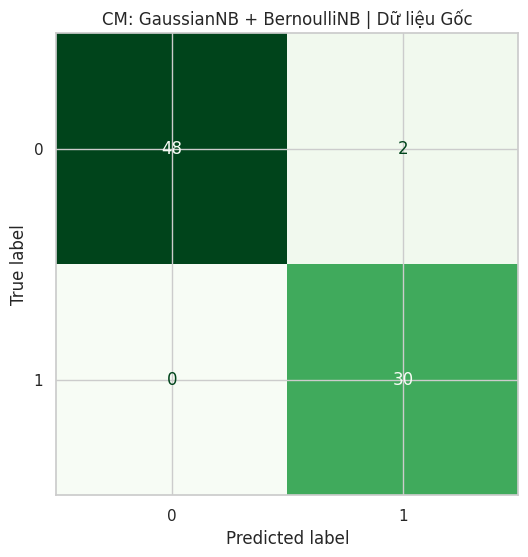

--------------------------------------------------
THỰC NGHIỆM: GaussianNB + BernoulliNB
Dữ liệu: Dữ liệu Gốc | Test size: 0.3
Accuracy: 0.9583
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        75
           1       0.90      1.00      0.95        45

    accuracy                           0.96       120
   macro avg       0.95      0.97      0.96       120
weighted avg       0.96      0.96      0.96       120



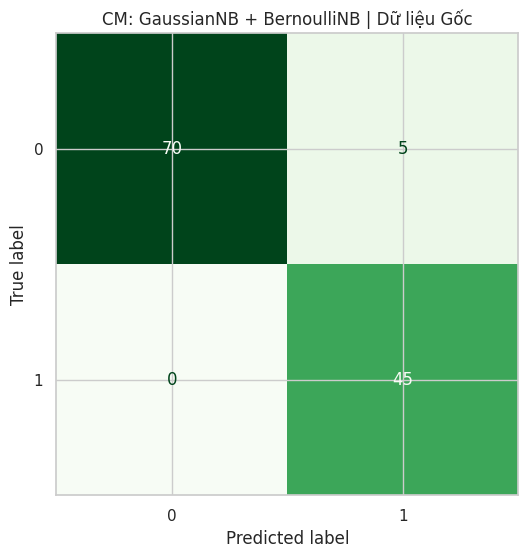

--------------------------------------------------
THỰC NGHIỆM: GaussianNB + BernoulliNB
Dữ liệu: Dữ liệu Gốc | Test size: 0.4
Accuracy: 0.9437
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       100
           1       0.87      1.00      0.93        60

    accuracy                           0.94       160
   macro avg       0.93      0.96      0.94       160
weighted avg       0.95      0.94      0.94       160



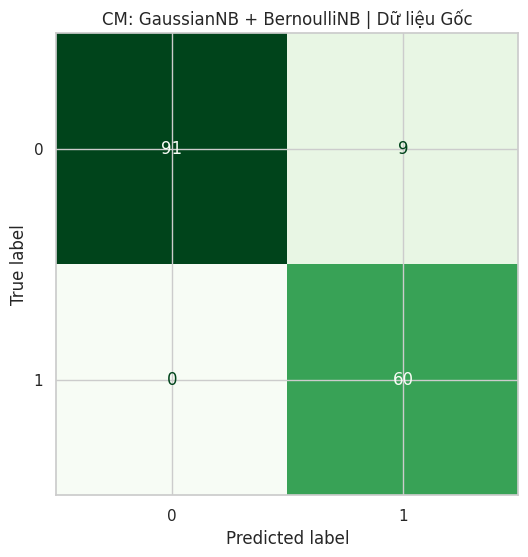

--------------------------------------------------
THỰC NGHIỆM: GaussianNB only
Dữ liệu: Dữ liệu PCA (6 CPs) | Test size: 0.2
Accuracy: 0.9875
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.97      1.00      0.98        30

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



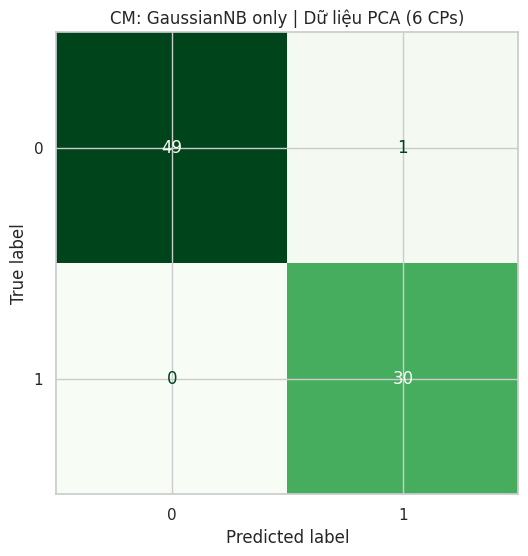

--------------------------------------------------
THỰC NGHIỆM: GaussianNB only
Dữ liệu: Dữ liệu PCA (6 CPs) | Test size: 0.3
Accuracy: 0.9833
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        75
           1       0.96      1.00      0.98        45

    accuracy                           0.98       120
   macro avg       0.98      0.99      0.98       120
weighted avg       0.98      0.98      0.98       120



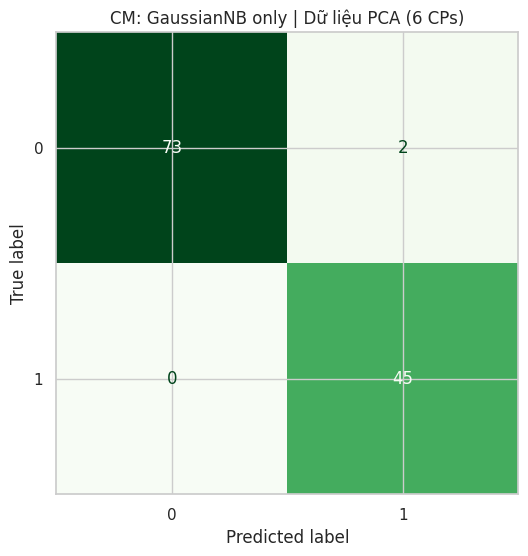

--------------------------------------------------
THỰC NGHIỆM: GaussianNB only
Dữ liệu: Dữ liệu PCA (6 CPs) | Test size: 0.4
Accuracy: 0.9812
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       100
           1       0.95      1.00      0.98        60

    accuracy                           0.98       160
   macro avg       0.98      0.98      0.98       160
weighted avg       0.98      0.98      0.98       160



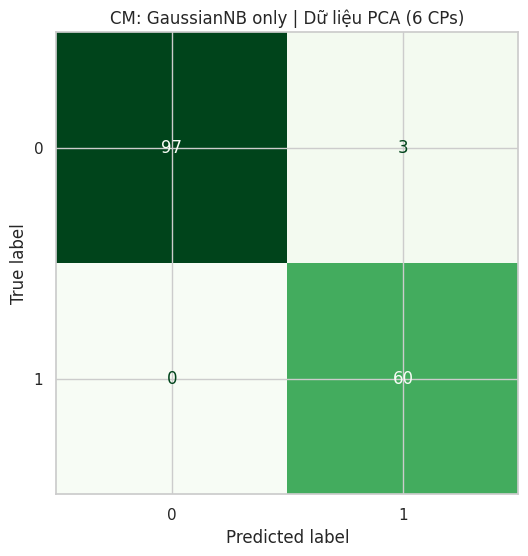

Dữ liệu <=1 cột, kiểm tra loại dữ liệu để chọn NB
Cột còn lại là continuous → dùng GaussianNB
--------------------------------------------------
THỰC NGHIỆM: GaussianNB only
Dữ liệu: Dữ liệu LDA (1 CP) | Test size: 0.2
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        30

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



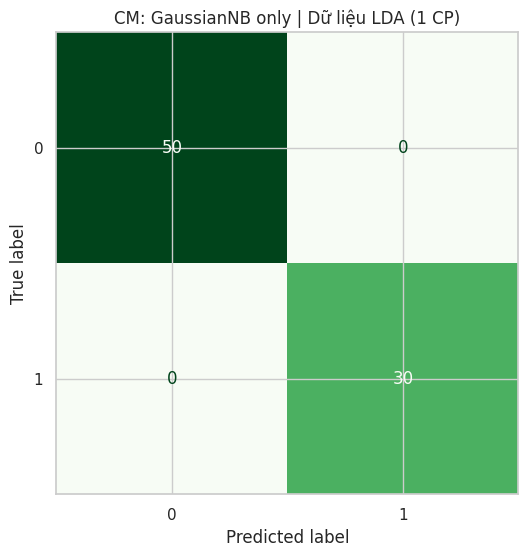

Dữ liệu <=1 cột, kiểm tra loại dữ liệu để chọn NB
Cột còn lại là continuous → dùng GaussianNB
--------------------------------------------------
THỰC NGHIỆM: GaussianNB only
Dữ liệu: Dữ liệu LDA (1 CP) | Test size: 0.3
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00        45

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



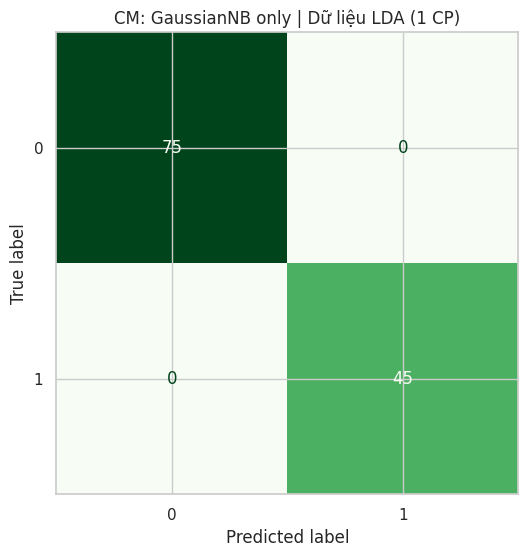

Dữ liệu <=1 cột, kiểm tra loại dữ liệu để chọn NB
Cột còn lại là continuous → dùng GaussianNB
--------------------------------------------------
THỰC NGHIỆM: GaussianNB only
Dữ liệu: Dữ liệu LDA (1 CP) | Test size: 0.4
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00        60

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



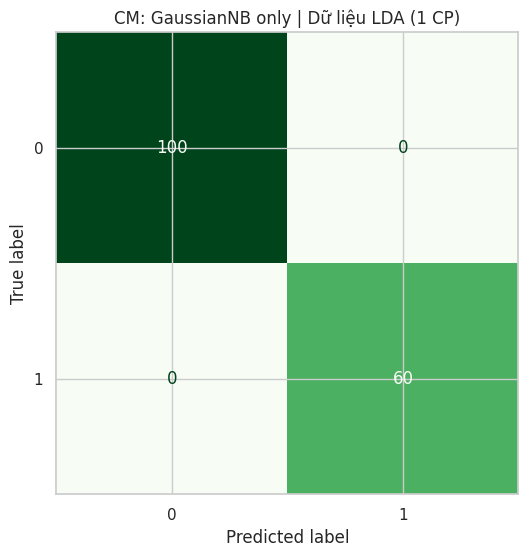



##################################################
 TỔNG KẾT KẾT QUẢ ACCURACY CỦA NAIVE BAYES
##################################################
     Dữ liệu Gốc  Dữ liệu PCA (6 CPs)  Dữ liệu LDA (1 CP)
4:1     0.975000             0.987500                 1.0
7:3     0.958333             0.983333                 1.0
6:4     0.943750             0.981250                 1.0


In [ ]:
# Lặp qua các kịch bản
print("\n==================================================")
print(" CHẠY CÁC PHÂN LOẠI KHÁC NHAU VỚI GaussianNB")
print("==================================================")

results_gnb = {}
for dataset_name, data in datasets_to_run.items():
    results_gnb[dataset_name] = {}
    for split_name, test_size in splits_to_run.items():
        acc = run_mixed_nb_experiment_safe_v2(data, y, dataset_name, test_size)
        results_gnb[dataset_name][split_name] = acc


# --- Tổng kết kết quả ---
print("\n\n##################################################")
print(" TỔNG KẾT KẾT QUẢ ACCURACY CỦA NAIVE BAYES")
print("##################################################")

df_results_gnb = pd.DataFrame(results_gnb)
print(df_results_gnb)


# Đánh giá Hiệu suất Mô hình Naive Bayes

**Tổng quan và So sánh Kết quả**

Mô hình Naive Bayes cho thấy hiệu suất vượt trội, với độ chính xác trên tập kiểm tra dao động từ 94.37% đến 100%.

1. Dữ liệu LDA (1 Đặc trưng): Cho kết quả hoàn hảo tuyệt đối (100% Accuracy) trên mọi tỉ lệ chia.

* Đánh giá: Dữ liệu LDA 1 chiều đã phân tách hai lớp rõ ràng (như đã thấy trong các biểu đồ trước). GaussianNB chỉ đơn giản là tìm thấy một ngưỡng (threshold) hoàn hảo để phân chia hai phân phối chuẩn (một của ckd, một của notckd), dẫn đến độ chính xác 100%.

2. Dữ liệu PCA (6 Đặc trưng): Cho kết quả rất tốt (98.1% - 98.75%).

* Đánh giá: Đây là một kết quả rất quan trọng. Hiệu suất trên PCA cao hơn hiệu suất trên Dữ liệu Gốc.

3. Dữ liệu Gốc (65 Đặc trưng): Cho kết quả thấp nhất (94.37% - 97.5%).

* Đánh giá: Dù vẫn rất cao, nhưng đây là kịch bản kém hiệu quả nhất.

**Đánh giá Hiện tượng Overfitting**

Kết luận: Hoàn toàn không có dấu hiệu Overfitting.

1. Độ chính xác Tập Test: Tất cả các chỉ số trên tập kiểm tra đều ở mức rất cao. Overfitting yêu cầu độ chính xác trên tập test phải thấp, điều này không xảy ra.

2. Độ ổn định: Mô hình cực kỳ ổn định. Ngay cả khi giảm dữ liệu huấn luyện (tăng test_size lên 0.4), độ chính xác trên PCA và LDA vẫn giữ nguyên ở mức ~98-100%. Điều này cho thấy khả năng tổng quát hóa rất tốt của mô hình.

# Mô hình Phân loại Logistic Regression kết hợp Hồi quy

**IMPORTS**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression # Mô hình hồi quy 1
from sklearn.ensemble import RandomForestRegressor # Mô hình hồi quy 2
from sklearn.metrics import mean_squared_error, r2_score

# Cài đặt chung cho đồ thị
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_theme(style="whitegrid")

**PHÂN LOẠI (LOGISTIC REGRESSION)**

In [ ]:
print("\n--- PHÂN LOẠI LOGISTIC REGRESSION ---")

# Hàm trợ giúp để chạy và báo cáo kết quả
def run_logistic_regression_experiment(X_data, y_data, dataset_name, test_size):
    """
    Hàm thực hiện huấn luyện, đánh giá Logistic Regression và vẽ Confusion Matrix.
    """
    print("--------------------------------------------------")
    print(f"THỰC NGHIỆM: Logistic Regression")
    print(f"   - Dữ liệu: {dataset_name}")
    print(f"   - Tỉ lệ chia (test_size): {test_size:.1f} (Train {1-test_size:.1f} : Test {test_size:.1f})")

    # 1. Chia dữ liệu
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                        test_size=test_size,
                                                        random_state=42,
                                                        stratify=y_data)

    # 2. Khởi tạo và Huấn luyện mô hình
    model = LogisticRegression(max_iter=1000, random_state=42)

    print(f"   >> [ĐANG HUẤN LUYỆN] Logistic Regression trên {dataset_name} (Split {test_size})...")
    model.fit(X_train, y_train)
    print(f"   >> [HUẤN LUYỆN XONG!]")

    # 3. Dự đoán
    y_pred = model.predict(X_test)

    # 4. Đánh giá
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n   -> Kết quả:")
    print(f"      - Accuracy: {accuracy:.4f}")

    print("\n      - Báo cáo Phân loại (Classification Report):")
    print(classification_report(y_test, y_pred, zero_division=0))

    # 5. Trực quan hóa kết quả (Confusion Matrix)
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Purples, colorbar=False)
    plt.title(f'Confusion Matrix: Logistic Reg. trên {dataset_name} (Test Size={test_size:.1f})')
    plt.show()
    print("--------------------------------------------------")

    return accuracy


--- PHÂN LOẠI LOGISTIC REGRESSION ---


**CHẠY CÁC THỰC NGHIỆM PHÂN LOẠI**


ĐANG CHẠY MÔ HÌNH TRÊN BỘ DỮ LIỆU: DỮ LIỆU GỐC
--------------------------------------------------
THỰC NGHIỆM: Logistic Regression
   - Dữ liệu: Dữ liệu Gốc
   - Tỉ lệ chia (test_size): 0.2 (Train 0.8 : Test 0.2)
   >> [ĐANG HUẤN LUYỆN] Logistic Regression trên Dữ liệu Gốc (Split 0.2)...
   >> [HUẤN LUYỆN XONG!]

   -> Kết quả:
      - Accuracy: 0.9875

      - Báo cáo Phân loại (Classification Report):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.97      1.00      0.98        30

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



<Figure size 800x600 with 0 Axes>

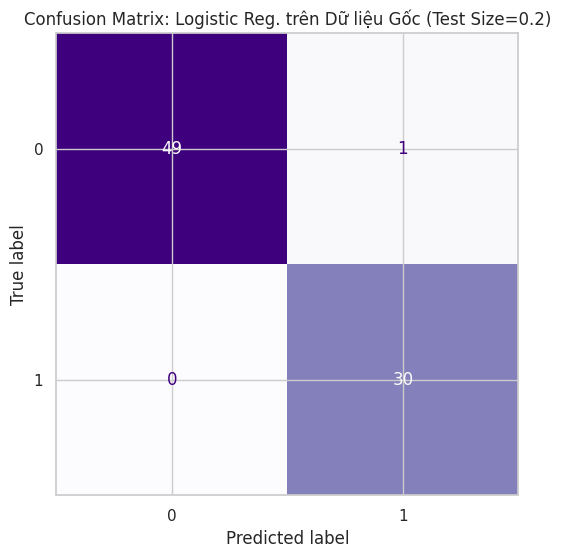

--------------------------------------------------
--------------------------------------------------
THỰC NGHIỆM: Logistic Regression
   - Dữ liệu: Dữ liệu Gốc
   - Tỉ lệ chia (test_size): 0.3 (Train 0.7 : Test 0.3)
   >> [ĐANG HUẤN LUYỆN] Logistic Regression trên Dữ liệu Gốc (Split 0.3)...
   >> [HUẤN LUYỆN XONG!]

   -> Kết quả:
      - Accuracy: 0.9833

      - Báo cáo Phân loại (Classification Report):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        75
           1       0.96      1.00      0.98        45

    accuracy                           0.98       120
   macro avg       0.98      0.99      0.98       120
weighted avg       0.98      0.98      0.98       120



<Figure size 800x600 with 0 Axes>

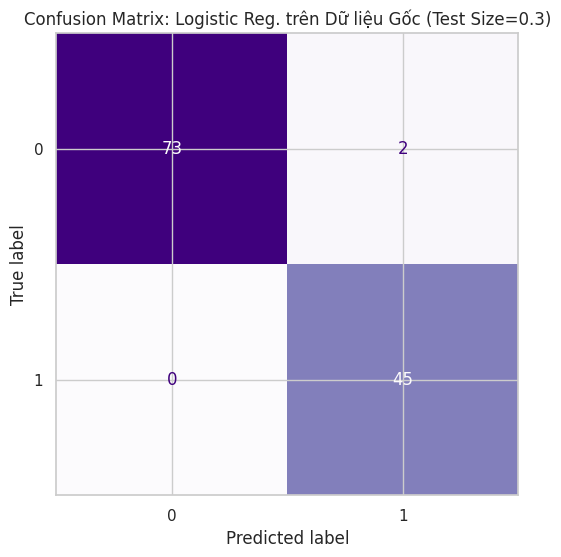

--------------------------------------------------
--------------------------------------------------
THỰC NGHIỆM: Logistic Regression
   - Dữ liệu: Dữ liệu Gốc
   - Tỉ lệ chia (test_size): 0.4 (Train 0.6 : Test 0.4)
   >> [ĐANG HUẤN LUYỆN] Logistic Regression trên Dữ liệu Gốc (Split 0.4)...
   >> [HUẤN LUYỆN XONG!]

   -> Kết quả:
      - Accuracy: 0.9875

      - Báo cáo Phân loại (Classification Report):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       100
           1       0.97      1.00      0.98        60

    accuracy                           0.99       160
   macro avg       0.98      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160



<Figure size 800x600 with 0 Axes>

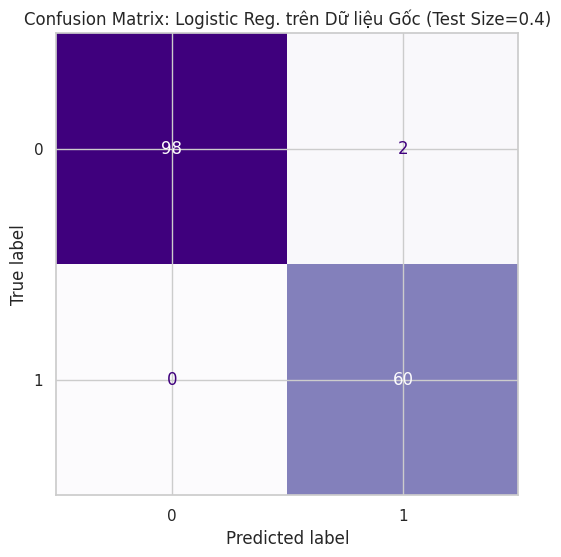

--------------------------------------------------

ĐANG CHẠY MÔ HÌNH TRÊN BỘ DỮ LIỆU: DỮ LIỆU PCA (6 CPS)
--------------------------------------------------
THỰC NGHIỆM: Logistic Regression
   - Dữ liệu: Dữ liệu PCA (6 CPs)
   - Tỉ lệ chia (test_size): 0.2 (Train 0.8 : Test 0.2)
   >> [ĐANG HUẤN LUYỆN] Logistic Regression trên Dữ liệu PCA (6 CPs) (Split 0.2)...
   >> [HUẤN LUYỆN XONG!]

   -> Kết quả:
      - Accuracy: 0.9750

      - Báo cáo Phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        50
           1       0.97      0.97      0.97        30

    accuracy                           0.97        80
   macro avg       0.97      0.97      0.97        80
weighted avg       0.97      0.97      0.97        80



<Figure size 800x600 with 0 Axes>

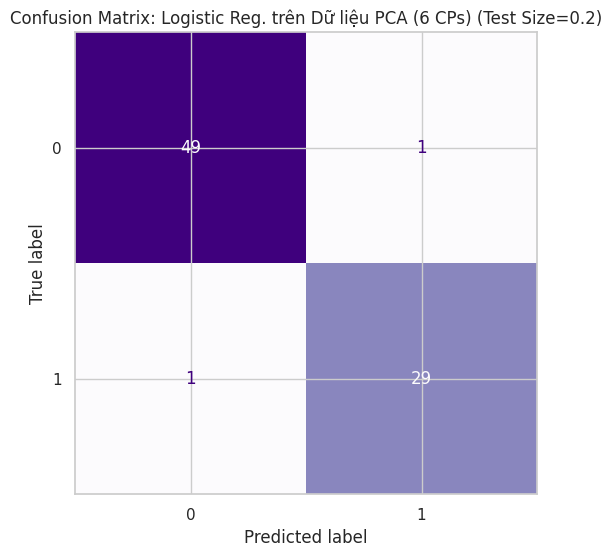

--------------------------------------------------
--------------------------------------------------
THỰC NGHIỆM: Logistic Regression
   - Dữ liệu: Dữ liệu PCA (6 CPs)
   - Tỉ lệ chia (test_size): 0.3 (Train 0.7 : Test 0.3)
   >> [ĐANG HUẤN LUYỆN] Logistic Regression trên Dữ liệu PCA (6 CPs) (Split 0.3)...
   >> [HUẤN LUYỆN XONG!]

   -> Kết quả:
      - Accuracy: 0.9750

      - Báo cáo Phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        75
           1       0.96      0.98      0.97        45

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.98      0.97      0.98       120



<Figure size 800x600 with 0 Axes>

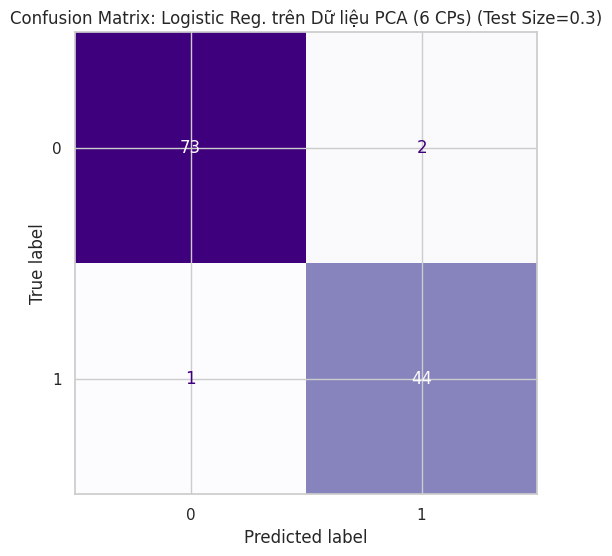

--------------------------------------------------
--------------------------------------------------
THỰC NGHIỆM: Logistic Regression
   - Dữ liệu: Dữ liệu PCA (6 CPs)
   - Tỉ lệ chia (test_size): 0.4 (Train 0.6 : Test 0.4)
   >> [ĐANG HUẤN LUYỆN] Logistic Regression trên Dữ liệu PCA (6 CPs) (Split 0.4)...
   >> [HUẤN LUYỆN XONG!]

   -> Kết quả:
      - Accuracy: 0.9750

      - Báo cáo Phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       100
           1       0.95      0.98      0.97        60

    accuracy                           0.97       160
   macro avg       0.97      0.98      0.97       160
weighted avg       0.98      0.97      0.98       160



<Figure size 800x600 with 0 Axes>

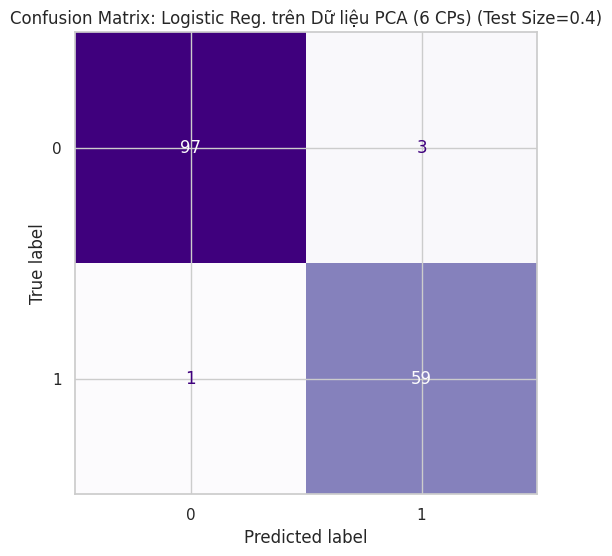

--------------------------------------------------

ĐANG CHẠY MÔ HÌNH TRÊN BỘ DỮ LIỆU: DỮ LIỆU LDA (1 CP)
--------------------------------------------------
THỰC NGHIỆM: Logistic Regression
   - Dữ liệu: Dữ liệu LDA (1 CP)
   - Tỉ lệ chia (test_size): 0.2 (Train 0.8 : Test 0.2)
   >> [ĐANG HUẤN LUYỆN] Logistic Regression trên Dữ liệu LDA (1 CP) (Split 0.2)...
   >> [HUẤN LUYỆN XONG!]

   -> Kết quả:
      - Accuracy: 1.0000

      - Báo cáo Phân loại (Classification Report):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        30

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



<Figure size 800x600 with 0 Axes>

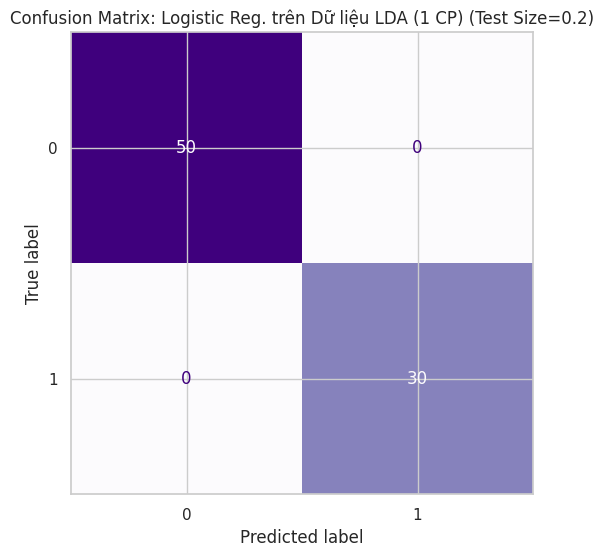

--------------------------------------------------
--------------------------------------------------
THỰC NGHIỆM: Logistic Regression
   - Dữ liệu: Dữ liệu LDA (1 CP)
   - Tỉ lệ chia (test_size): 0.3 (Train 0.7 : Test 0.3)
   >> [ĐANG HUẤN LUYỆN] Logistic Regression trên Dữ liệu LDA (1 CP) (Split 0.3)...
   >> [HUẤN LUYỆN XONG!]

   -> Kết quả:
      - Accuracy: 1.0000

      - Báo cáo Phân loại (Classification Report):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00        45

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



<Figure size 800x600 with 0 Axes>

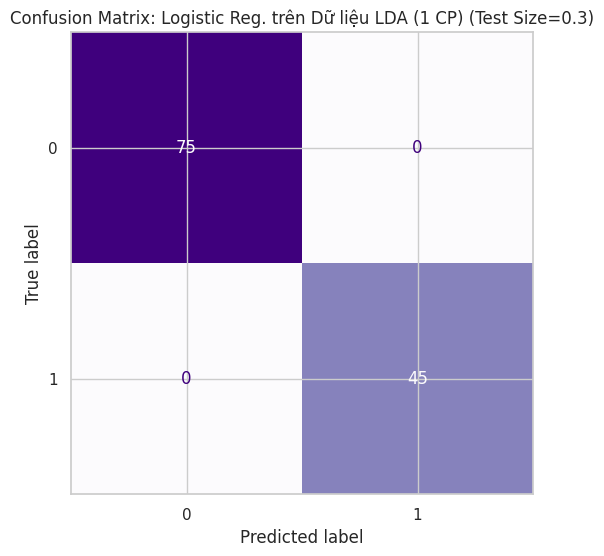

--------------------------------------------------
--------------------------------------------------
THỰC NGHIỆM: Logistic Regression
   - Dữ liệu: Dữ liệu LDA (1 CP)
   - Tỉ lệ chia (test_size): 0.4 (Train 0.6 : Test 0.4)
   >> [ĐANG HUẤN LUYỆN] Logistic Regression trên Dữ liệu LDA (1 CP) (Split 0.4)...
   >> [HUẤN LUYỆN XONG!]

   -> Kết quả:
      - Accuracy: 1.0000

      - Báo cáo Phân loại (Classification Report):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00        60

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



<Figure size 800x600 with 0 Axes>

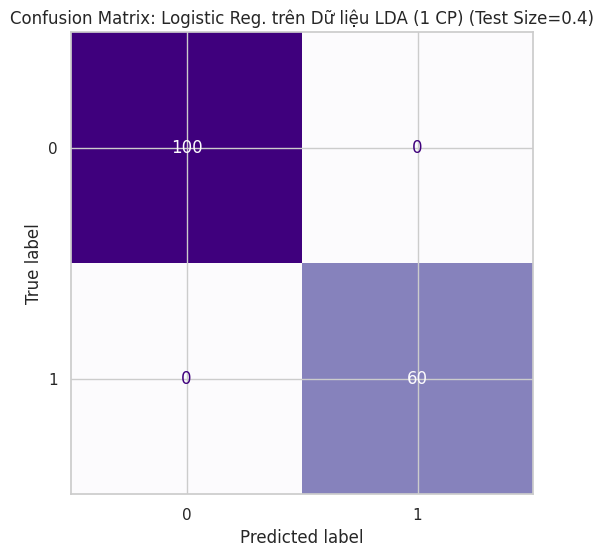

--------------------------------------------------


##################################################
 TỔNG KẾT KẾT QUẢ ACCURACY (Logistic Regression)
##################################################
     Dữ liệu Gốc  Dữ liệu PCA (6 CPs)  Dữ liệu LDA (1 CP)
4:1     0.987500                0.975                 1.0
7:3     0.983333                0.975                 1.0
6:4     0.987500                0.975                 1.0


In [ ]:
# Danh sách các bộ dữ liệu
datasets_to_run = {
    "Dữ liệu Gốc": X_processed,
    "Dữ liệu PCA (6 CPs)": X_pca,
    "Dữ liệu LDA (1 CP)": X_lda
}

# Danh sách các tỉ lệ chia
splits_to_run = {
    "4:1": 0.2,
    "7:3": 0.3,
    "6:4": 0.4
}

# Lặp qua tất cả các kịch bản
results_logistic = {} # Dùng để lưu kết quả
for dataset_name, data in datasets_to_run.items():
    results_logistic[dataset_name] = {}
    print(f"\n==================================================")
    print(f"ĐANG CHẠY MÔ HÌNH TRÊN BỘ DỮ LIỆU: {dataset_name.upper()}")
    print(f"==================================================")

    for split_name, test_size in splits_to_run.items():
        acc = run_logistic_regression_experiment(data, y, dataset_name, test_size)
        results_logistic[dataset_name][split_name] = acc

# --- Tổng kết kết quả ---
print("\n\n##################################################")
print(" TỔNG KẾT KẾT QUẢ ACCURACY (Logistic Regression)")
print("##################################################")

df_results_logistic = pd.DataFrame(results_logistic)
print(df_results_logistic)

# Đánh giá Hiệu suất Mô hình Logistic Regression

**Tổng quan và So sánh Kết quả**

Mô hình Hồi quy Logistic cho thấy hiệu suất vượt trội và cực kỳ ổn định trên cả ba bộ dữ liệu, với độ chính xác (Accuracy) trên tập kiểm tra luôn ở mức từ 97.5% đến 100%.

Kết quả chi tiết khi so sánh các loại dữ liệu đầu vào:

1.   Dữ liệu LDA (1 Đặc trưng): Đây là kịch bản cho kết quả hoàn hảo tuyệt đối. Mô hình đạt 100% độ chính xác trên tất cả các tỉ lệ chia.

  *   Đánh giá: Hồi quy Logistic là một mô hình phân loại tuyến tính. LDA là một phương pháp giảm chiều tuyến tính, có giám sát, với mục tiêu tìm ra 1 trục (thành phần) duy nhất để phân tách các lớp một cách tối đa.
  *   Việc mô hình tuyến tính (Logistic Regression) đạt 100% độ chính xác trên dữ liệu do LDA tạo ra là một bằng chứng rõ ràng: Dữ liệu CKD, khi được chiếu lên trục LDA, là hoàn toàn có thể phân tách tuyến tính (perfectly linearly separable).
2.   Dữ liệu Gốc (65 Đặc trưng): Đây là kịch bản cho kết quả cao thứ hai (98.3% - 98.75%).
  *   Đánh giá: Ngay cả trong không gian 65 chiều (nhiều nhiễu và đặc trưng không liên quan), mô hình Hồi quy Logistic vẫn tìm thấy một "siêu phẳng" (hyperplane) phân chia hai lớp một cách hiệu quả.

3. Dữ liệu PCA (6 Đặc trưng): Đây là kịch bản cho kết quả thấp nhất (luôn là 97.5%).
  *   Đánh giá: PCA là một phương pháp không giám sát, nó giảm chiều bằng cách tối đa hóa phương sai (giữ lại nhiều thông tin nhất) chứ không quan tâm đến việc phân tách các lớp.
  *   Việc hiệu suất giảm (từ ~98.7% xuống 97.5%) cho thấy 6 thành phần chính của PCA, tuy giữ được nhiều phương sai, nhưng có thể đã vô tình loại bỏ một số thông tin quan trọng (dù nhỏ) mà Hồi quy Logistic cần để phân loại chính xác 100%.

**Đánh giá Hiện tượng Overfitting**

Kết luận: Hoàn toàn không có dấu hiệu Overfitting.

Mô hình Hồi quy Logistic cho thấy khả năng tổng quát hóa (generalization) rất tốt.
1. Độ ổn định: Thay đổi tỉ lệ chia (từ 80:20 xuống 60:40) gần như không ảnh hưởng đến hiệu suất của mô hình. Trên dữ liệu PCA và LDA, độ chính xác là hằng số tuyệt đối. Điều này chứng tỏ mô hình đã "học" được quy luật cốt lõi của dữ liệu và không phụ thuộc vào việc có thêm hay bớt dữ liệu huấn luyện.
2. Độ chính xác trên tập Test: Tất cả các chỉ số trên tập kiểm tra (Accuracy, Precision, Recall, F1-score) đều ở mức gần như hoàn hảo.
3. Kết quả 100%: Như đã giải thích, độ chính xác 100% trên dữ liệu LDA không phải là overfitting. Đó là sự xác nhận rằng ranh giới phân loại mà LDA tìm thấy là hoàn hảo, và mô hình Hồi quy Logistic đã học được ranh giới đó.

**CHUYỂN LOGISTIC SANG HỒI QUY (TẠO y_reg)**

In [ ]:
print("\n--- HỒI QUY TỪ LOGISTIC REGRESSION ---")

# --- Xây dựng đầu ra mới (y_reg) ---
# Dùng hàm quyết định (decision function) của Logistic Regression
print("Đang tạo 'y' mới cho bài toán hồi quy...")

# 1. Huấn luyện 1 mô hình Logistic Regression trên TOÀN BỘ dữ liệu gốc
model_for_regression = LogisticRegression(max_iter=1000, random_state=42)
model_for_regression.fit(X_processed, y)

# 2. Lấy "decision function score" cho TẤT CẢ các mẫu
y_reg = model_for_regression.decision_function(X_processed)

print(f"Đã tạo y_reg (đầu ra mới). Shape: {y_reg.shape}")
print(f"Giá trị y_reg (min, max, mean): ({y_reg.min():.2f}, {y_reg.max():.2f}, {y_reg.mean():.2f})")


--- HỒI QUY TỪ LOGISTIC REGRESSION ---
Đang tạo 'y' mới cho bài toán hồi quy...
Đã tạo y_reg (đầu ra mới). Shape: (400,)
Giá trị y_reg (min, max, mean): (-27.25, 7.58, -3.32)


**TẠO DỮ LIỆU GIẢM CHIỀU (1/3 SỐ CHIỀU)**

In [ ]:
print("Đang tạo dữ liệu 'X' giảm chiều 1/3...")

# 1. Tính số chiều
n_features_original = X_processed.shape[1]
n_components_1_3 = int(n_features_original / 3)
if n_components_1_3 == 0: n_components_1_3 = 1

print(f"Số chiều gốc: {n_features_original}. Số chiều 1/3: {n_components_1_3}")

# 2. Chạy PCA mới
pca_1_3 = PCA(n_components=n_components_1_3, random_state=42)
X_pca_1_3 = pca_1_3.fit_transform(X_processed)

print(f"Đã tạo X_pca_1_3 (dữ liệu 1/3). Shape: {X_pca_1_3.shape}")

Đang tạo dữ liệu 'X' giảm chiều 1/3...
Số chiều gốc: 65. Số chiều 1/3: 21
Đã tạo X_pca_1_3 (dữ liệu 1/3). Shape: (400, 21)


**HÀM CHẠY THỰC NGHIỆM HỒI QUY**

In [ ]:
def run_regression_experiment(X_reg_data, y_reg_data, regressor_model, model_name, dataset_name, test_size):
    """
    Hàm thực hiện huấn luyện và đánh giá một mô hình HỒI QUY.
    """
    print("--------------------------------------------------")
    print(f"THỰC NGHIỆM HỒI QUY:")
    print(f"   - Mô hình: {model_name}")
    print(f"   - Dữ liệu: {dataset_name}")
    print(f"   - Tỉ lệ chia (test_size): {test_size:.1f}")

    # 1. Chia dữ liệu
    # KHÔNG DÙNG 'stratify' vì y_reg là biến liên tục!
    X_train, X_test, y_train, y_test = train_test_split(X_reg_data, y_reg_data,
                                                        test_size=test_size,
                                                        random_state=42)

    # 2. Huấn luyện mô hình
    model = regressor_model

    # Thêm print để biết đang chạy
    print(f"   >> [ĐANG HUẤN LUYỆN] {model_name} trên {dataset_name} (Split {test_size})...")
    model.fit(X_train, y_train)
    print(f"   >> [HUẤN LUYỆN XONG!]")

    # 3. Dự đoán
    y_pred = model.predict(X_test)

    # 4. Đánh giá (Dùng MSE và R-squared)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n   -> Kết quả:")
    print(f"      - Mean Squared Error (MSE): {mse:.4f}")
    print(f"      - R-squared (R2 Score): {r2:.4f}")
    print("--------------------------------------------------")

    return {'model': model_name, 'dataset': dataset_name,
            'split': f"{1-test_size:.1f}:{test_size:.1f}",
            'mse': mse, 'r2': r2}


**CHẠY THỰC NGHIỆM HỒI QUY**

In [ ]:
print("\n--- Đang chạy các kịch bản Hồi quy ---")

# 1. Các mô hình Hồi quy cần chạy
regressors_to_run = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(random_state=42, n_estimators=100)
}

# 2. Các bộ dữ liệu Hồi quy cần chạy
datasets_reg_to_run = {
    "Dữ liệu Gốc": X_processed,
    "Dữ liệu PCA (1/3)": X_pca_1_3
}

# 3. Các tỉ lệ chia
splits_to_run = {
    "4:1": 0.2,
    "7:3": 0.3,
    "6:4": 0.4
}

# Lặp qua tất cả các kịch bản
results_regression = []
for model_name, model in regressors_to_run.items():
    for dataset_name, data in datasets_reg_to_run.items():
        for split_name, test_size in splits_to_run.items():

            # Chạy thực nghiệm và lưu kết quả
            res = run_regression_experiment(data, y_reg, model, model_name, dataset_name, test_size)
            results_regression.append(res)


--- Đang chạy các kịch bản Hồi quy ---
--------------------------------------------------
THỰC NGHIỆM HỒI QUY:
   - Mô hình: Linear Regression
   - Dữ liệu: Dữ liệu Gốc
   - Tỉ lệ chia (test_size): 0.2
   >> [ĐANG HUẤN LUYỆN] Linear Regression trên Dữ liệu Gốc (Split 0.2)...
   >> [HUẤN LUYỆN XONG!]

   -> Kết quả:
      - Mean Squared Error (MSE): 0.0004
      - R-squared (R2 Score): 1.0000
--------------------------------------------------
--------------------------------------------------
THỰC NGHIỆM HỒI QUY:
   - Mô hình: Linear Regression
   - Dữ liệu: Dữ liệu Gốc
   - Tỉ lệ chia (test_size): 0.3
   >> [ĐANG HUẤN LUYỆN] Linear Regression trên Dữ liệu Gốc (Split 0.3)...
   >> [HUẤN LUYỆN XONG!]

   -> Kết quả:
      - Mean Squared Error (MSE): 0.0003
      - R-squared (R2 Score): 1.0000
--------------------------------------------------
--------------------------------------------------
THỰC NGHIỆM HỒI QUY:
   - Mô hình: Linear Regression
   - Dữ liệu: Dữ liệu Gốc
   - Tỉ lệ chia 

**TỔNG KẾT KẾT QUẢ HỒI QUY**

In [ ]:
print("\n\n##################################################")
print(" TỔNG KẾT KẾT QUẢ (Hồi quy)")
print("##################################################")

df_results_reg = pd.DataFrame(results_regression)

# Sắp xếp lại để dễ so sánh
df_results_reg = df_results_reg.pivot_table(
    index=['dataset', 'split'],
    columns='model',
    values=['mse', 'r2']
)

print(df_results_reg)



##################################################
 TỔNG KẾT KẾT QUẢ (Hồi quy)
##################################################
                                        mse                          \
model                     Linear Regression Random Forest Regressor   
dataset           split                                               
Dữ liệu Gốc       0.6:0.4          0.000209                2.677604   
                  0.7:0.3          0.000278                3.018588   
                  0.8:0.2          0.000418                3.284782   
Dữ liệu PCA (1/3) 0.6:0.4          0.050534                1.878726   
                  0.7:0.3          0.053279                1.675750   
                  0.8:0.2          0.053564                1.545201   

                                         r2                          
model                     Linear Regression Random Forest Regressor  
dataset           split                                              
Dữ liệu Gốc       

# Đánh giá Thực nghiệm Hồi quy (Chuyển đổi từ Phân loại)

Thí nghiệm này được thiết kế để kiểm tra khả năng của các mô hình hồi quy (Linear Regression, Random Forest Regressor) trong việc học lại hàm quyết định (decision function) của mô hình Logistic Regression.

**So sánh Kết quả Thực nghiệm**

Kết quả cho thấy sự khác biệt rất rõ ràng về cách hai mô hình hồi quy xử lý dữ liệu gốc và dữ liệu giảm chiều.

1. Linear Regression:

  * Trên Dữ liệu Gốc (65 đặc trưng): Cho kết quả hoàn hảo (R-squared ≈ 1.0000, MSE ≈ 0.0003).

  * Trên Dữ liệu PCA (1/3, ~21 đặc trưng): Hiệu suất giảm (R-squared ≈ 0.9990, MSE ≈ 0.05).

2. Random Forest Regressor:

  * Trên Dữ liệu Gốc (65 đặc trưng): Cho kết quả tốt (R-squared ≈ 0.94), nhưng kém xa so với Linear Regression.

  * Trên Dữ liệu PCA (1/3, ~21 đặc trưng): Hiệu suất được cải thiện (R-squared ≈ 0.97).

**Giải thích Kết quả**

Các kết quả trái ngược nhau này là hoàn toàn logic và có thể được giải thích như sau:

1. Lý do Linear Regression đạt R2 = 1.0
Đây là kết quả quan trọng nhất và không phải là overfitting. Nó là một kết quả logic, mang tính "tuần hoàn" do chính thiết kế của thực nghiệm:

* Tạo mục tiêu: Biến mục tiêu mới (y_reg) được tạo ra từ decision_function của mô hình Logistic Regression.

* Bản chất: Hàm decision_function của Logistic Regression về cơ bản là một hàm tuyến tính của các đặc trưng đầu vào (có dạng w1x1 + w2x2 +...+b).

* Thực nghiệm: Chúng ta yêu cầu mô hình Linear Regression (một mô hình tuyến tính) đi tìm mối quan hệ giữa X (đầu vào) và y_reg (một hàm tuyến tính của X).

Kết luận: Mô hình Linear Regression đã giải bài toán một cách hoàn hảo vì bản thân bài toán chính là một phương trình tuyến tính. Nó đã tìm ra chính xác các trọng số mà mô hình Logistic Regression đã sử dụng.

2. Lý do Random Forest kém hơn trên Dữ liệu Gốc
Random Forest là một mô hình phi tuyến (non-linear).

* Khi chạy trên Dữ liệu Gốc, chúng ta đang yêu cầu một mô hình phi tuyến cố gắng xấp xỉ (approximate) một hàm tuyến tính hoàn hảo.

* Nó đã xấp xỉ rất tốt (R2 = 0.94), nhưng không thể hoàn hảo bằng một mô hình tuyến tính thực thụ trên chính bài toán tuyến tính đó.

3. Lý do hiệu suất hai mô hình đảo ngược trên Dữ liệu PCA
* Linear Regression giảm hiệu suất do:

    *Biến mục tiêu y_reg được tạo ra từ 65 đặc trưng gốc.*

    *Dữ liệu PCA (1/3) chỉ còn ~21 đặc trưng. Dù 21 đặc trưng này giữ lại phần lớn thông tin, nhưng nó đã mất mát thông tin so với 65 đặc trưng ban đầu.*

* Random Forest tăng hiệu suất do:

    *Với 65 đặc trưng, dữ liệu bị nhiễu và thưa thớt, khiến Random Forest khó xây dựng cây hiệu quả.*

    *PCA (1/3) đã dọn nhiễu và cô đặc thông tin vào ~21 đặc trưng quan trọng nhất. Điều này giúp Random Forest hoạt động hiệu quả hơn, dẫn đến R2 tăng (từ 0.94 lên 0.97) và MSE giảm đáng kể.*